In [5]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

"""
Question 1)  Using mid-prices, find all the arbitrages in butterfly spreads with adjacent strike prices.

Question 2)  Using bid- and ask-quotes, find all the butterfly spread arbitrages.
"""

# Date: 7-Aug-2018
# Maturity: 21-Jun-2019
# Expiration: 318

# Need to convert expiration in days to expiration in years
period = 318/365

# C = S + P - K*exp(-rT)
r = -(0.0244 + 1)
stock = 379.57
forward = 387.73


In [6]:
spread = pd.read_excel('./ButterflyHomework.xlsx', skiprows=12)
# Need to use skiprows=12 to get the proper dataframe formatting

spread.head()

,strike,Vol 8/7,Fitted Vol,Black-Scholes Call,Bid,Mid,Ask
0,55,0.957070,0.693550,326.325944,325.325944,326.325944,327.325944
1,60,0.902117,0.685908,321.378535,320.378535,321.378535,322.378535
2,65,0.851266,0.678353,316.431076,315.431076,316.431076,317.431076
3,70,0.876616,0.670885,311.858668,310.858668,311.858668,312.858668
4,75,0.758869,0.663504,306.536247,305.536247,306.536247,307.536247


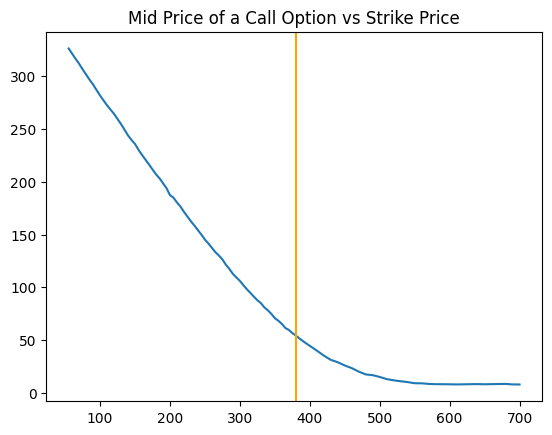

In [7]:
plt.plot(spread['strike'], spread['Mid'])
#plt.plot(spread['strike'], spread['Black-Scholes Call'])
plt.title("Mid Price of a Call Option vs Strike Price")
plt.axvline(x = stock, color = 'orange', label = 'axvline - full height')
plt.show()

# Question 1

There are 52 arbitrage opportunities, or center strike prices where the net spread of the butterfly is <0


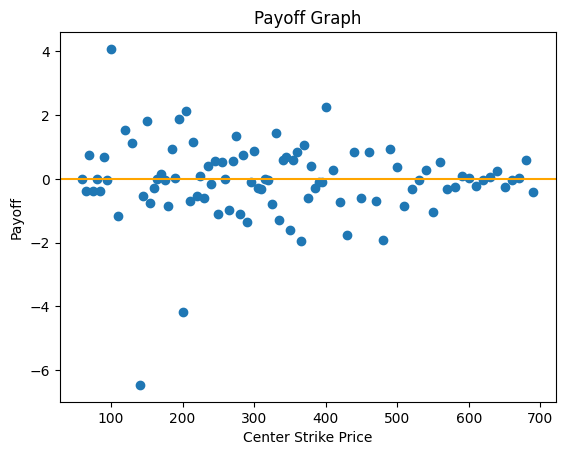

In [150]:
# This function returns the payoff of a call option, as we've learned in class
def payoff(s, k):
    return max([0, (s-k)])
counter = 0
arr = []
centerKs = []
arb = []
for index, row in spread.iterrows():
    if index > 0 and index < 95:
        a = -spread.loc[index-1]['Mid']
        b = 2*spread.loc[index]['Mid']
        c = -spread.loc[index+1]['Mid']
        
        # Buy one call at lowest price, sell 2 calls at the middle price, and buy 1 call at the higher price
        #arbitrage occurs when net spread < 0
        money = a+b+c
        if (money < 0):
            centerKs.append(spread.loc[index-1]['strike'])
            arb.append(money)
            counter += 1
        arr.append(money)
print("There are " + str(counter) + " arbitrage opportunities, or center strike prices where the net spread of the butterfly is <0")
plt.scatter(spread['strike'][1:95], arr)
plt.axhline(y = 0, color = 'orange', label = 'axvline - full height')
plt.xlabel("Center Strike Price")
plt.ylabel("Payoff")
plt.title("Payoff Graph")
plt.show()

In [85]:
data = []
for i in range(0, len(arb)):
    data.append([arb[i], centerKs[i]])
q1Arbs = pd.DataFrame(data=data, columns=['Arbitrage Value', 'Center Strike Price'])
q1Arbs.head()

,Arbitrage Value,Center Strike Price
0,-0.375051,65.0
1,-0.382561,75.0
2,-0.009954,80.0
3,-0.382478,85.0
4,-0.024118,95.0


# Question 2

In [86]:
import itertools
strike_prices = spread.strike

# combinations will contain all unique triples of strike prices
combinations = list(itertools.combinations(strike_prices, 3))
print("There are " + str(len(combinations)) + " unique combinations")

There are 142880 unique combinations


In [87]:
def lcm(x, y):
    return (x*y)/(math.gcd(x, y))

def lcm_float(a, b, precision):
    a = round(a, precision)
    b = round(b, precision)
    return lcm(int(a*10**precision), int(b*10**precision))/10**precision

In [133]:
from fractions import Fraction

def weights(low, mid, high):
    A = np.array([[low, high], [1, 1]])
    b = np.array([mid, 1])
    x = np.linalg.solve(A, b)
    f1 = Fraction(x[0]).limit_denominator().numerator
    f2 = Fraction(x[1]).limit_denominator().numerator
    return [f1, f2]

In [136]:
data = []
counter = 0
for combo in combinations:
    
    coefs = weights(combo[0], combo[1], combo[2])
    a = -1 * coefs[0] * spread.loc[spread['strike'] == combo[0]]['Ask'].iloc[0]
    b = np.sum(coefs) * (spread.loc[spread['strike'] == combo[1]])['Bid'].iloc[0]
    c = -1 * coefs[1] * (spread.loc[spread['strike'] == combo[2]])['Ask'].iloc[0]
    data.append([combo[0], coefs[0], combo[1], np.sum(coefs), combo[2], coefs[1], (a+b+c)])
    
final = pd.DataFrame(data=data, columns=['Low K', '# at Low K', "Middle K", "# at Middle K", "High K", "N# at High K", "Arbitrage Value"])

In [151]:
final.loc[abs(final['Arbitrage Value']) > (final['High K'] - final['Low K'])]

,Low K,# at Low K,Middle K,# at Middle K,High K,N# at High K,Arbitrage Value
168,55,91,65,93,520,2,-475.823451
169,55,93,65,95,530,2,-497.900795
170,55,95,65,97,540,2,-520.079162
171,55,97,65,99,550,2,-541.681577
172,55,99,65,101,560,2,-565.356373
...,...,...,...,...,...,...,...
140172,440,13,550,24,680,11,-263.909927
140173,440,14,550,25,690,11,-279.045607
140174,440,15,550,26,700,11,-298.699951
140187,440,13,560,25,690,12,-259.476869


In [158]:
x = len(final.loc[abs(final['Arbitrage Value']) > (final['High K'] - final['Low K'])])
y = len(final['Low K'])
print(
    "When we use all possible option combinations, sell at the bid, and buy at the ask, there are \n" + 
    str(x) + 
    " arbitrage opportunities, which is " + 
    str((x/y)*100) + " percent of combinations available."
)

When we use all possible option combinations, sell at the bid, and buy at the ask, there are 
87534 arbitrage opportunities, which is 61.26399776035834 percent of combinations available.
